In [1]:
using JuMP, Gurobi, IPG

In [2]:
n = m = 2

X1 = Model()
@variable(X1, x1[1] >= 0, start=10.0)

X2 = Model()
@variable(X2, x2[1] >= 0, start=10.0)

players = [
    Player(X1, QuadraticPayoff(0, [2, 1]), 1),
    Player(X2, QuadraticPayoff(0, [1, 2]), 2)
]

┌ Warning: Axis contains one element: 1. If intended, you can safely ignore this warning. To explicitly pass the axis with one element, pass `[1]` instead of `1`.
└ @ JuMP.Containers /home/vscode/.julia/packages/JuMP/CU7H5/src/Containers/DenseAxisArray.jl:185
┌ Warning: Axis contains one element: 1. If intended, you can safely ignore this warning. To explicitly pass the axis with one element, pass `[1]` instead of `1`.
└ @ JuMP.Containers /home/vscode/.julia/packages/JuMP/CU7H5/src/Containers/DenseAxisArray.jl:185


2-element Vector{Player}:
 Player(A JuMP Model
├ solver: none
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 1
├ num_constraints: 1
│ └ VariableRef in MOI.GreaterThan{Float64}: 1
└ Names registered in the model
  └ :x1, QuadraticPayoff([0.0], [[2.0;;], [1.0;;]]), 1)
 Player(A JuMP Model
├ solver: none
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 1
├ num_constraints: 1
│ └ VariableRef in MOI.GreaterThan{Float64}: 1
└ Names registered in the model
  └ :x2, QuadraticPayoff([0.0], [[1.0;;], [2.0;;]]), 2)

In [4]:
const global GRB_ENV = Gurobi.Env()
σ = IPG.SGM(players, () -> Gurobi.Optimizer(GRB_ENV))
# TODO: I have no idea why it seems to be creating new gurobi envs at each optimization

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Acad

2-element Vector{DiscreteMixedStrategy}:
 DiscreteMixedStrategy([1.0], [[0.01953125]])
 DiscreteMixedStrategy([1.0], [[0.0390625]])

# TODO: Plots

In [16]:
using Plots

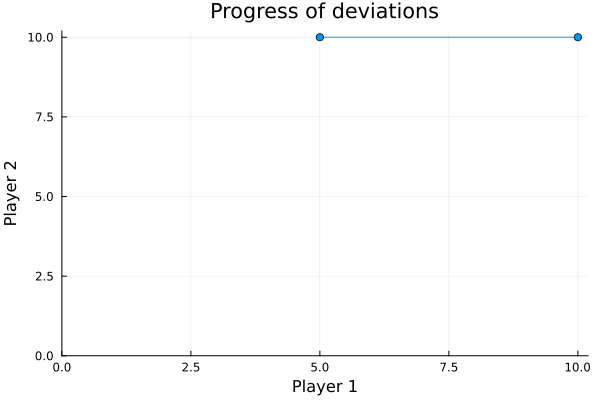

In [19]:
k = 1
points = []
while true
    i::Integer = floor(k / 2) + 1
    j::Integer = floor((k-1) / 2) + 1

    if i > length(S_X[1]) || j > length(S_X[2])
        break
    else
        push!(points, [S_X[1][i][1], S_X[2][j][1]])
        k += 1
    end
end

plot([p[1] for p in points], [p[2] for p in points], marker=:c, title="Progress of deviations", legend=false)
# plot!(xscale=:log10, yscale=:log10)
xlabel!("Player 1")
ylabel!("Player 2")
xlims!(0,10.2)
ylims!(0,10.2)